# Problem Description
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships. One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class. In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

# Goal
Predict if a PASSENGER SURVIVED the sinking of the Titanic or not. For each in the test set, you must predict a 0 or 1 value for the variable.

The data has been split into two groups:

training set (train.csv)
test set (test.csv)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

- Variable Name	Description
- Survived	Survived (1) or died (0)
- Pclass	Passenger’s class
- Name	Passenger’s name
- Sex	Passenger’s sex
- Age	Passenger’s age
- SibSp	Number of siblings/spouses aboard
- Parch	Number of parents/children aboard
- Ticket	Ticket number
- Fare	Fare
- Cabin	Cabin
- Embarked	Port of embarkation

In [5]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('./src')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold

In [7]:
from eda import bivariate_plot, col_types, impute_missing, missing_value_summary, data_summary
from sklearn_utils import coef_df, f_classif, logistic_reg_coef_df, univariate_f_classif, vif, var_importance

## Loading data

In [8]:
raw_data = pd.read_csv('data/no_use/titanic_raw.csv'
                       ,
                       na_values='?'
            #,nrows = 10
                      )
raw_data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [9]:
raw_data.shape

(1309, 14)

In [10]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


## data engineering

In [11]:
model_data = raw_data.drop(['name', 'ticket'], axis = 1)
model_data = model_data.replace('?', np.nan)
model_data['age'] = model_data['age'].astype(float)
model_data['fare'] = model_data['fare'].astype(float)
model_data['pclass'] = model_data['pclass'].astype(str)

In [12]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   object 
 1   survived   1309 non-null   int64  
 2   sex        1309 non-null   object 
 3   age        1046 non-null   float64
 4   sibsp      1309 non-null   int64  
 5   parch      1309 non-null   int64  
 6   fare       1308 non-null   float64
 7   cabin      295 non-null    object 
 8   embarked   1307 non-null   object 
 9   boat       486 non-null    object 
 10  body       121 non-null    float64
 11  home.dest  745 non-null    object 
dtypes: float64(3), int64(3), object(6)
memory usage: 122.8+ KB


In [13]:
data_summary(model_data)

,count,mean,std,min,25%,50%,75%,max,missing,missing %,1.5iqr outliers,outliers %
survived,1309.0,0.381971,0.486055,0.0000,0.0000,0.0000,1.000,1.0000,0,0.00,0,0.00
age,1046.0,29.881135,14.413500,0.1667,21.0000,28.0000,39.000,80.0000,263,20.09,9,0.86
sibsp,1309.0,0.498854,1.041658,0.0000,0.0000,0.0000,1.000,8.0000,0,0.00,57,4.35
parch,1309.0,0.385027,0.865560,0.0000,0.0000,0.0000,0.000,9.0000,0,0.00,307,23.45
fare,1308.0,33.295479,51.758668,0.0000,7.8958,14.4542,31.275,512.3292,1,0.08,171,13.07
body,121.0,160.809917,97.696922,1.0000,72.0000,155.0000,256.000,328.0000,1188,90.76,0,0.00


In [14]:
missings = missing_value_summary(model_data, 'survived')
missings

,tot count,missing,missing %,non-missing avg,missing avg
pclass,1309,0,0.00,0.381971,NaN
survived,1309,0,0.00,0.381971,NaN
sex,1309,0,0.00,0.381971,NaN
age,1309,263,20.09,0.408222,0.277567
sibsp,1309,0,0.00,0.381971,NaN
parch,1309,0,0.00,0.381971,NaN
fare,1309,1,0.08,0.382263,0.000000
cabin,1309,1014,77.46,0.654237,0.302761
embarked,1309,2,0.15,0.381025,1.000000
boat,1309,823,62.87,0.981481,0.027947


In [15]:
model_data = model_data.drop(['home.dest','body','boat','cabin'], axis = 1)
model_data = model_data[model_data['fare'].notna()]

In [18]:
y_col = 'survived'
num_cols, cat_cols = col_types(model_data, y_col)

Numerical Columns are:


['age', 'sibsp', 'parch', 'fare']


 Categorical Columns are:


['pclass', 'sex', 'embarked']

In [19]:
cat_cols

['pclass', 'sex', 'embarked']

## visualization

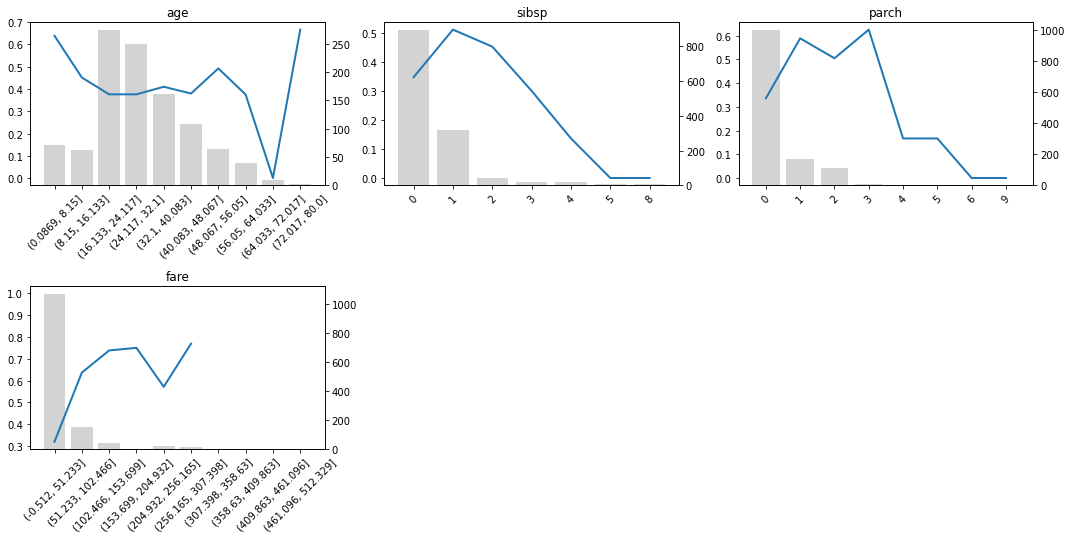

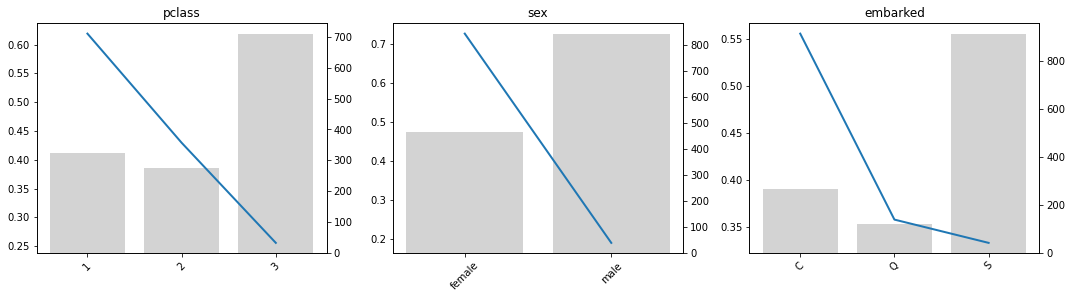

In [20]:
bivariate_plot(model_data, y_col, binary=True)

<AxesSubplot:xlabel='fare', ylabel='Count'>

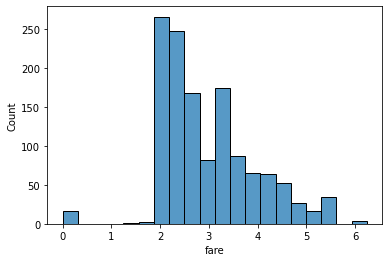

In [21]:
sns.histplot(np.log1p(model_data['fare']), bins = 20)

In [22]:
model_data['age'] = model_data['age'].fillna(40)
model_data['log_fare'] = np.log1p(model_data['fare'])

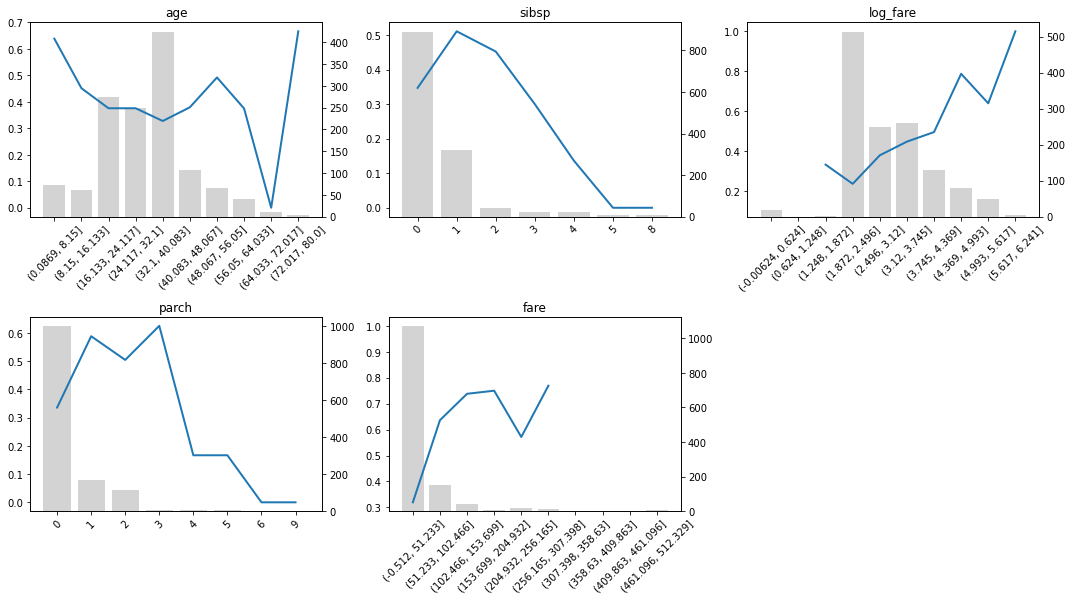

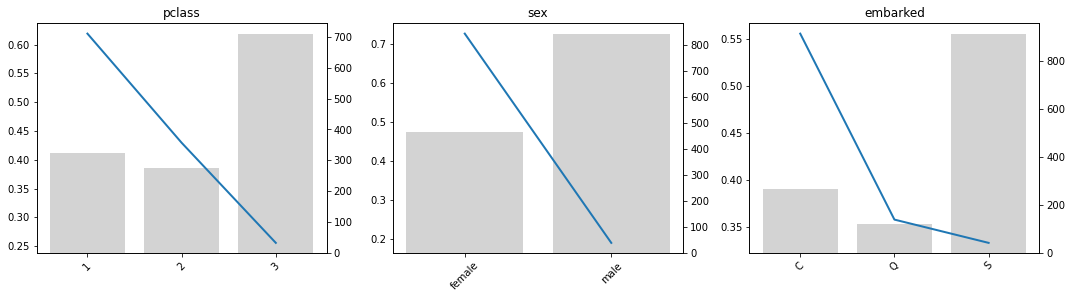

In [23]:
bivariate_plot(model_data, y_col, binary=True)

## Feature selection


In [24]:
dummy_df = pd.get_dummies(model_data[cat_cols])
model_data_with_dummy = pd.concat([model_data, dummy_df], axis = 1)
model_data_with_dummy['parch_ind'] = model_data_with_dummy.apply(lambda r: 0 if r['parch'] < 1 else 1, axis = 1)
model_data_with_dummy.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,log_fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,parch_ind
0,1,1,female,29.0000,0,0,211.3375,S,5.358177,1,0,0,1,0,0,0,1,0
1,1,1,male,0.9167,1,2,151.5500,S,5.027492,1,0,0,0,1,0,0,1,1
2,1,0,female,2.0000,1,2,151.5500,S,5.027492,1,0,0,1,0,0,0,1,1
3,1,0,male,30.0000,1,2,151.5500,S,5.027492,1,0,0,0,1,0,0,1,1
4,1,0,female,25.0000,1,2,151.5500,S,5.027492,1,0,0,1,0,0,0,1,1


In [25]:
model_vars = ['age', 'fare', 'pclass_1',  'pclass_2','sex_male', 'embarked_C', 'embarked_Q', 'parch_ind']

In [26]:
model_data_with_dummy[model_vars].corr()

,age,fare,pclass_1,pclass_2,sex_male,embarked_C,embarked_Q,parch_ind
age,1.000000,0.124593,0.312963,-0.068409,0.072371,0.078941,0.083289,-0.257911
fare,0.124593,1.000000,0.600031,-0.121384,-0.185523,0.286269,-0.130059,0.243105
pclass_1,0.312963,0.600031,1.000000,-0.296820,-0.107081,0.325572,-0.166269,0.021706
pclass_2,-0.068409,-0.121384,-0.296820,1.000000,-0.028577,-0.134905,-0.122118,0.026427
sex_male,0.072371,-0.185523,-0.107081,-0.028577,1.000000,-0.066294,-0.088490,-0.239664
embarked_C,0.078941,0.286269,0.325572,-0.134905,-0.066294,1.000000,-0.164315,0.047371
embarked_Q,0.083289,-0.130059,-0.166269,-0.122118,-0.088490,-0.164315,1.000000,-0.122798
parch_ind,-0.257911,0.243105,0.021706,0.026427,-0.239664,0.047371,-0.122798,1.000000


In [27]:
vif(model_data_with_dummy, model_vars)

,feature,VIF
2,pclass_1,2.007000
1,fare,1.747230
7,parch_ind,1.231502
0,age,1.229335
3,pclass_2,1.158756
5,embarked_C,1.158043
6,embarked_Q,1.144840
4,sex_male,1.118483


## Logistic model

In [28]:
train, test = train_test_split(model_data_with_dummy, train_size = 0.7, random_state = 0)
train = train.copy()
test = test.copy()

In [29]:
lr_mod = LogisticRegression(penalty='l2', max_iter = 1000, solver = 'liblinear')  # no regularization
lr_mod.fit(train[model_vars], train[y_col] )

LogisticRegression(max_iter=1000, solver='liblinear')

In [30]:
logistic_reg_coef_df(lr_mod, model_vars)

,Estimate
Intercept,1.074366
age,-0.031623
fare,-0.001519
pclass_1,1.941141
pclass_2,0.890558
sex_male,-2.384785
embarked_C,0.594863
embarked_Q,0.358550
parch_ind,0.219931


In [31]:
lr_mod.score(train[model_vars], train[y_col])

0.7956284153005464

In [32]:
lr_mod.score(test[model_vars], test[y_col])

0.7913486005089059

In [33]:
test['lr_pred'] = lr_mod.predict(test[model_vars])
train['lr_pred'] = lr_mod.predict(train[model_vars])

In [34]:
tt = train[['log_fare','fare','survived', 'lr_pred']].copy()

In [35]:
tt['bins'] = pd.cut(tt['fare'], bins = 10)

In [36]:
agg = tt.groupby(by = 'bins', as_index=False).agg({'survived':'mean', 'lr_pred':'mean'})

<BarContainer object of 10 artists>

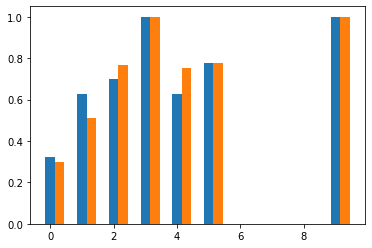

In [37]:
pos = np.array(range(10))
plt.bar(pos, agg['survived'], width=0.3)
plt.bar(pos+0.3, agg['lr_pred'], width=0.3)

In [38]:
tt.groupby(by = 'bins', as_index=False).agg({'survived':'mean', 'lr_pred':['count','mean']})

bins  survived lr_pred          
                           mean   count      mean
0    (-0.512, 51.233]  0.321237     744  0.299731
1   (51.233, 102.466]  0.628319     113  0.513274
2  (102.466, 153.699]  0.700000      30  0.766667
3  (153.699, 204.932]  1.000000       2  1.000000
4  (204.932, 256.165]  0.625000      16  0.750000
5  (256.165, 307.398]  0.777778       9  0.777778
6   (307.398, 358.63]       NaN       0       NaN
7   (358.63, 409.863]       NaN       0       NaN
8  (409.863, 461.096]       NaN       0       NaN
9  (461.096, 512.329]  1.000000       1  1.000000

## Randomg forest

In [39]:
rf_clf = RandomForestClassifier()
hp = GridSearchCV(
    rf_clf,
    param_grid={
            'n_estimators': range(80,120,10),
            'max_depth': range(4,7,1),
            'min_samples_leaf':range(1,4),
            'ccp_alpha': [0.0001,0.0005, 0.001]
    },
    cv = KFold(shuffle=True),
    n_jobs = -1
    ).fit(train[model_vars], train[y_col])

In [40]:
hp.best_estimator_

RandomForestClassifier(ccp_alpha=0.0005, max_depth=6, min_samples_leaf=3,
                       n_estimators=80)

In [41]:
rf_model = hp.best_estimator_.fit(train[model_vars], train[y_col])


In [42]:
rf_model.score(train[model_vars], train[y_col])

0.8459016393442623

In [43]:
rf_model.score(test[model_vars], test[y_col])

0.806615776081425

In [44]:
var_importance(rf_model,model_vars)

,Importance,cumsum
sex_male,0.448279,0.448
fare,0.193944,0.642
age,0.134569,0.777
pclass_1,0.102422,0.879
pclass_2,0.039980,0.919
embarked_C,0.036662,0.956
parch_ind,0.034331,0.990
embarked_Q,0.009813,1.000
